In [1]:
import numpy as np
import scipy as sp
import sys

sys.version


'3.3.5 |Anaconda 2.2.0 (64-bit)| (default, Sep  2 2014, 13:55:40) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import time

import ssm_timeSeries as ts  # my self-written time series overhead
import ssm_fit               # my self-written library for state-space model fitting

from IPython import display  # for live plotting

import random
from datetime import datetime     # generate random seed for 
random.seed(datetime.now())       # np.random. Once this is fixed, all 
rngSeed = random.randint(0, 1000) # other 'randomness' is also fixed

from scipy.io import savemat # store results for comparison with Matlab code

xDim = 1
yDim = 15

T = 100000
#obsScheme = {'subpops': [list(range(0,yDim)), list(range(0,yDim))],
#             'obsTime': [round(T/4), T],
#             'obsPops': [0, 1]}
while True:
    W    = np.random.normal(size=[xDim,xDim])
    if np.abs(np.linalg.det(W)) > 0.001:
        break
A    = np.diag(np.linspace(0.3,0.8,xDim))  #np.diag(np.random.uniform(size=[xDim]))
A    = np.dot(np.dot(W, A), np.linalg.inv(W))
Qnoise = np.random.normal(size=[xDim,xDim])/4
Qnoise = np.dot(Qnoise, Qnoise.transpose())
Q    = np.identity(xDim) + Qnoise
mu0  = np.random.normal(size=[xDim]) #np.random.normal(size=[xDim])
V0   = np.identity(xDim)
C = np.random.normal(size=[yDim, xDim])
R = np.identity(yDim) + np.diag(np.abs(np.random.normal(size=[yDim])))
R[0,0] = 5
R[1,1] = 3
R[2,2] = 9
R[3,3] = 4

d = np.random.normal(size=yDim)
d = 5 * np.arange(yDim)

uDim = 1
B = 1 + np.random.normal(size=[xDim,uDim])/25
#B = 0 * B
#u = np.ones([uDim, T, 1])
#u[:,range(int(T/2)),0] = -1
u = np.random.normal(size=[uDim, T, 1])

seq = ts.setStateSpaceModel('iLDS', [xDim,yDim,uDim], [A,B,Q,mu0,V0,C,d,R])  # initiate true model
seq.giveEmpirical().addData(1,T,[u],rngSeed)                                # draw toy data

# check implementation of E- and M- step by doing one such step each:
x = seq.giveEmpirical().giveData().giveTracesX()
y = seq._empirical._data.giveTracesY()                                             

no data model. Assuming data is given by real experiment or other external source
checking factorization of model ...
... factorization (locally) describes directed acyclic graph
no data model. Assuming data is given by real experiment or other external source
checking factorization of model ...
... factorization (locally) describes directed acyclic graph


In [4]:
[Ext, Extxt, Extxtm1,LL0]    = ssm_fit._iLDS_E_step(A_0,B_0,Q_0,mu0_0,V0_0,C_0,d_0,R_0, 
                                                   y,u,obsScheme)    # do one E-step 
[A_1,B_1,Q_1,mu0_1,V0_1,C_1,d_1,R_1,my,syy,suu,suuinv,Ti] = ssm_fit._iLDS_M_step(Ext, 
                                                                                Extxt, 
                                                                                Extxtm1, 
                                                                                y, u,
                                                                                obsScheme) # do one M-step
[Ext1, Extxt1, Extxtm11,LL1] = ssm_fit._iLDS_E_step(A_1,B_1,Q_1,mu0_1,V0_1,C_1,d_1,R_1, 
                                                   y,u,obsScheme)   # do another E-step
[Ext_true, Extxt_true, Extxtm1_true, LLtr] = ssm_fit._iLDS_E_step(A,B,Q,mu0,V0,C,d,R,
                                                                 y,u,obsScheme)


subpops
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]
A
[[ 0.0993823]]
B
[[ 0.43075559]]
Q
[[ 4.31624432]]
C
[[ 0.25909188]
 [ 0.2006726 ]
 [-0.70248776]
 [-0.25251739]
 [ 0.23144229]
 [-0.5021528 ]
 [-0.27537619]
 [-0.17610447]
 [ 0.33165754]
 [-0.12317432]
 [ 0.06331675]
 [-0.12889514]
 [ 0.2567168 ]
 [ 0.29712635]
 [ 0.18671547]]
d
[ -0.12920718   4.89946241  10.37601507  15.14188004  19.87952488
  25.25926814  30.13608407  35.08845438  39.82720225  45.06064622
  49.95959796  55.06819802  59.86543618  64.8433489   69.90308132]
R
[  5.97121115   5.93914042  15.05648589   5.88908065   3.48099359
  10.5904388    4.95744373   2.84727639   7.59531911   1.77507032
   2.41756989   2.68486595   4.17758573   4.61557738   2.41882038]


subpops
[[5, 6, 7, 8, 9, 10, 11, 12, 13, 14], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
A
[[ 0.95271727]]
B
[[-0.63251608]]
Q
[[ 18.71666158]]
C
[[-0.13004281]
 [-0.18997995]
 [ 0.31087291]
 [ 0.16611592]
 [-0.12952615]
 [ 0.05930421]
 [ 0.03225597]
 [ 0.02064415]
 [-0.04450173]
 [ 0.01403515]
 [ 0.14718826]
 [-0.19245765]
 [ 0.38140977]
 [ 0.3954634 ]
 [ 0.25040712]]
d
[  0.30206962   5.43119977   9.30555938  14.63420177  20.29253075
  24.51095346  29.72791484  34.82729327  40.36555977  44.88132348
  46.11824557  60.07620062  49.95598614  54.56681024  63.40585291]
R
[  5.39122214   4.2466526   12.23412532   4.74672353   2.83817428
  11.13790578   5.12469401   2.91557431   7.7665602    1.81022558
   2.15913331   2.22089522   2.05116345   2.47006115   1.66552144]


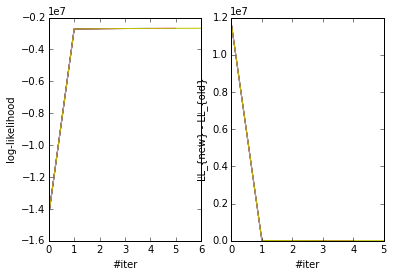

In [ ]:
subpops = [list(range(5,yDim)), list(range(0,yDim-5))]
obsTime = [int(round(T/4)), T]
obsPops = [0,1]
obsScheme = {'subpops': subpops,
             'obsTime': obsTime,
             'obsPops': obsPops}
[obsIdxG, idxgrps] = ssm_fit._computeObsIndexGroups(obsScheme,yDim)
obsScheme['obsIdxG'] = obsIdxG # add index groups and 
obsScheme['idxgrps'] = idxgrps # their occurences        

# initiate parameters for analysis model
A_0   = np.diag(np.random.uniform(size=[xDim]))
Q_0   = 50*np.identity(xDim)              
mu0_0 = 5*np.random.normal(size=[xDim])   
V0_0  = 50*np.identity(xDim)               
C_0   = np.random.normal(size=[yDim,xDim]) 
d_0   = np.random.normal(size=yDim)          
R_0   = 50*np.identity(yDim)    
B_0   = 0 * np.random.normal(size=[xDim, uDim])


seq = ts.setStateSpaceModel('iLDS', [xDim,yDim,uDim], [A_0,B_0,Q_0,mu0_0,V0_0,C_0,d_0,R_0], seq) # adds analysis model 
model = seq.analysis1.giveModel()                                                     

t = time.time()
LLs = seq.analysis1.fitModel(10,           # maxIter                             
                             np.log(1.00001), # stop if likelihood change < 0.001%
                             None,
                             0, 
                             None, 
                             None,
                             obsScheme,
                             True,
                             True)
elapsedTime = time.time() - t
print('elapsed time for fitting is')
print(elapsedTime)
[A_h,B_h,Q_h,mu0_h,V0_h,C_h,d_h,R_h] = model.givePars().copy()

[Ext_h, Extxt_h, Extxtm1_h, LL_h]          = ssm_fit._iLDS_E_step(A_h,B_h,Q_h,mu0_h,V0_h,C_h,d_h,R_h, 
                                                                 y,u,obsScheme)


Pi_h    = np.array([sp.linalg.solve_discrete_lyapunov(A_h, Q_h)])[0,:,:]
Pi_t_h  = np.dot(A_h.transpose(), Pi_h)

Pi    = np.array([sp.linalg.solve_discrete_lyapunov(A, Q)])[0,:,:]
Pi_t  = np.dot(A.transpose(), Pi)

dataCov  = np.cov(y[:,0:T-1,0], y[:,1:T,0])
covyy    = dataCov[np.ix_(np.arange(0, yDim), np.arange(0,     yDim))]
covyy_m1 = dataCov[np.ix_(np.arange(0, yDim), np.arange(yDim,2*yDim))]

plt.figure(1)
cmap = matplotlib.cm.get_cmap('brg')
clrs = [cmap(i) for i in np.linspace(0, 1, xDim)]
for i in range(xDim):
    plt.subplot(xDim,1,i)
    plt.plot(x[i,:,0], color=clrs[i])
    plt.hold(True)
    if np.mean( np.square(x[i,:,0] - Ext_h[i,:,0]) ) < np.mean( np.square(x[i,:,0] + Ext_h[i,:,0]) ):
        plt.plot( Ext_h[i,:,0], color=clrs[i], ls=':')
    else:
        plt.plot(-Ext_h[i,:,0], color=clrs[i], ls=':')
m = covyy.min()
M = covyy.max()        
plt.figure(2)
plt.subplot(1,3,1)
plt.imshow(np.dot(np.dot(C_h, Pi_h), C_h.transpose()) + R_h, interpolation='none')
plt.title('cov_hat(y_t,y_t)')
plt.clim(m,M)
plt.subplot(1,3,2)
plt.imshow(covyy,    interpolation='none')
plt.title('cov_emp(y_t,y_t)')
plt.clim(m,M)
plt.subplot(1,3,3)
plt.imshow(np.dot(np.dot(C, Pi), C.transpose()) + R, interpolation='none')
plt.title('cov_true(y_t,y_t)')
plt.clim(m,M)
plt.figure(3)

m = covyy_m1.min()
M = covyy_m1.max()        
plt.subplot(1,3,1)
plt.imshow(np.dot(np.dot(C_h, Pi_t_h), C_h.transpose()), interpolation='none')
plt.title('cov_hat(y_t,y_{t-1})')
plt.clim(m,M)
plt.subplot(1,3,2)
plt.imshow(covyy_m1,    interpolation='none')
plt.title('cov(y_t,y_{t-1})')
plt.clim(m,M)
plt.subplot(1,3,3)
plt.imshow(np.dot(np.dot(C, Pi_t), C.transpose()), interpolation='none')
plt.title('cov_true(y_t,y_{t-1})')
plt.clim(m,M)
plt.figure(4)
plt.plot(np.sort(np.linalg.eig(A)[0]), 'r')
plt.hold(True)
plt.plot(np.sort(np.linalg.eig(A_h)[0]), 'b')
plt.legend(['true', 'est'])


#matlabSaveFile = {'x': x, 'y': y, 'u' : u, 
#                  'A':A, 'B':B, 'Q':Q, 'mu0':mu0,'V0':V0,'C':C,'d':d,'R':R,
#                  'A_0':A_0, 'B_0':B_0, 'Q_0':Q_0, 'mu0_0':mu0_0,'V0_0':V0_0,'C_0':C_0,'d_0':d_0,'R_0':R_0,
#                  'A_1':A_1, 'B_1':B_1, 'Q_1':Q_1, 'mu0_1':mu0_1,'V0_1':V0_1,'C_1':C_1,'d_1':d_1,'R_1':R_1,
#                  'A_h':A_h, 'Q_h':Q_h, 'mu0_h':mu0_h,'V0_h':V0_h,'C_h':C_h,'R_h':R_h,
#                  'Ext':Ext, 'Extxt':Extxt, 'Extxtm1':Extxtm1,
#                  'T':T,
#                  'LL0': LL0, 'LL1': LL1}
#savemat('LDS_data.mat',matlabSaveFile)



offset
0.0272458657097


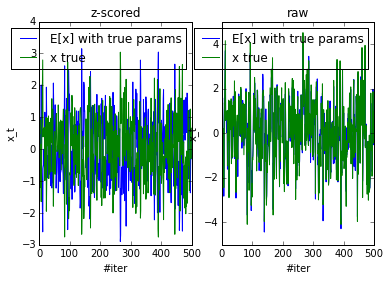

In [6]:
plotRange = range(52000, 52500)
plt.subplot(1,2,1)
plt.plot((Ext_true[0,plotRange,0] - np.mean(Ext_true[0,plotRange,0]))/np.std(Ext_true[0,plotRange,0]))
plt.plot(x[0,plotRange,0]/np.std(x[0,plotRange,0]))
plt.xlabel('#iter')
plt.ylabel('x_t')
plt.legend(['E[x] with true params', 'x true'])
plt.title('z-scored')
plt.subplot(1,2,2)
plt.plot(Ext_true[0,plotRange,0])
plt.plot(x[0,plotRange,0])
plt.xlabel('#iter')
plt.ylabel('x_t')
plt.legend(['E[x] with true params', 'x true'])
plt.title('raw')
print('offset')
print(np.mean(Ext_true[0,plotRange,0]))

offset
0.348495999578


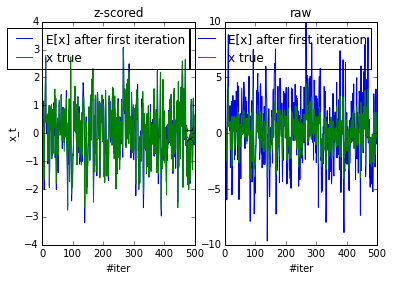

In [14]:
plotRange = range(52000, 52500)
plt.subplot(1,2,1)
plt.plot((Ext1[0,plotRange,0] - np.mean(Ext1[0,plotRange,0]))/np.std(Ext1[0,plotRange,0]))
plt.plot(x[0,plotRange,0]/np.std(x[0,plotRange,0]))
plt.xlabel('#iter')
plt.ylabel('x_t')
plt.legend(['E[x] after first iteration', 'x true'])
plt.title('z-scored')
plt.subplot(1,2,2)
plt.plot(Ext1[0,plotRange,0])
plt.plot(x[0,plotRange,0])
plt.xlabel('#iter')
plt.ylabel('x_t')
plt.legend(['E[x] after first iteration', 'x true'])
plt.title('raw')
print('offset')
print(np.mean(Ext1[0,plotRange,0]))


In [ ]:
plotRange = range(92000, 92200)

plt.subplot(1,2,1)
plt.plot((Ext_h[0,plotRange,0] - np.mean(Ext_h[0,plotRange,0]))/np.std(Ext_h[0,plotRange,0]))
plt.plot(x[0,plotRange,0]/np.std(x[0,plotRange,0]))
plt.xlabel('#iter')
plt.ylabel('x_t')
plt.legend(['E[x] after last iteration', 'x true'])
plt.title('z-scored')
plt.subplot(1,2,2)
plt.plot(Ext_h[0,plotRange,0])
plt.plot(x[0,plotRange,0])
plt.xlabel('#iter')
plt.ylabel('x_t')
plt.legend(['E[x] after last iteration', 'x true'])
plt.title('raw')
print('offset')
print(np.mean(Ext_h[0,plotRange,0]))

print('scale [in E[xt]]')
print(np.std(Ext_h[0,plotRange,0])/np.std(x[0,plotRange,0]))
print('scale [in Q]')
print(np.sqrt(Q_h / Q))

A_0
[[ 0.16972784]]
A
[[ 0.3]]
A_h
[[ 0.30350916]]
B_0
[[ 0.]]
B
[[ 0.94765503]]
B_h
[[ 2.08647958]]
Q_0
[[ 50.]]
Q
[[ 1.02225009]]
Q_h
[[ 5.53077125]]


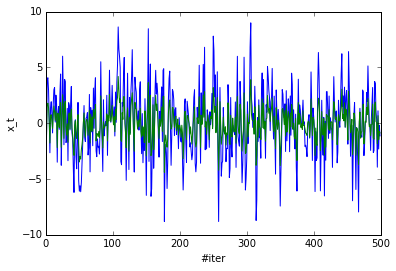

In [9]:
plotRange = range(2000, 2500)

#plt.plot(Ext_true[0,plotRange,0])
plt.plot(Ext_h[0,plotRange,0])
plt.plot(x[0,plotRange,0])
plt.xlabel('#iter')
plt.ylabel('x_t')
print('A_0')
print(A_0)
print('A')
print(A)
print('A_h')
print(A_h)
print('B_0')
print(B_0)
print('B')
print(B)
print('B_h')
print(B_h)
print('Q_0')
print(Q_0)
print('Q')
print(Q)
print('Q_h')
print(Q_h)

In [ ]:
plt.subplot(1,4,1)
plt.title('C_0')
plt.imshow(C_0, interpolation='none')
plt.subplot(1,4,2)
plt.title('C')
plt.imshow(C, interpolation='none')
plt.subplot(1,4,3)
plt.title('C_h')
plt.imshow(C_h, interpolation='none')
plt.subplot(1,4,4)
plt.title('C_h / C')
plt.imshow(C_h / C, interpolation='none')
plt.colorbar()

In [ ]:
plt.subplot(1,4,1)
plt.title('d_0')
plt.imshow(d_0.reshape(yDim,1), interpolation='none')
plt.subplot(1,4,2)
plt.title('d')
plt.imshow(d.reshape(yDim,1), interpolation='none')
plt.subplot(1,4,3)
plt.title('d_h')
plt.imshow(d_h.reshape(yDim,1), interpolation='none')
plt.subplot(1,4,4)
plt.title('d_h / d')
plt.imshow((d_h / d).reshape(yDim,1), interpolation='none')
plt.colorbar()
print(d_0)
print(d)
print(d_h)

[[ 50.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.  50.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.  50.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.  50.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.  50.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.  50.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.  50.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.  50.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  50.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.  50.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  50.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  50.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   0

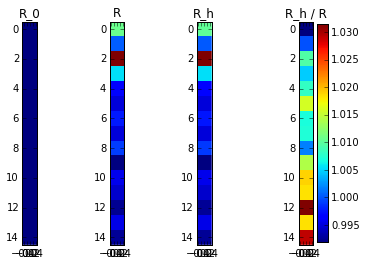

In [12]:
plt.subplot(1,4,1)
plt.title('R_0')
plt.imshow(R_0.diagonal().reshape(yDim,1), interpolation='none')
plt.subplot(1,4,2)
plt.title('R')
plt.imshow(R.diagonal().reshape(yDim,1), interpolation='none')
plt.subplot(1,4,3)
plt.title('R_h')
plt.imshow(R_h.diagonal().reshape(yDim,1), interpolation='none')
plt.subplot(1,4,4)
plt.title('R_h / R')
plt.imshow((R_h.diagonal() / R.diagonal()).reshape(yDim,1), interpolation='none')
plt.colorbar()
print(R_0)
print(R)
print(R_h)

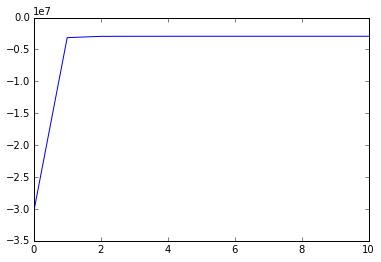

In [13]:
plt.plot(LLs)

In [7]:
matlabSaveFile = {'x': x, 'y': y, 'u' : u, 
                  'A':A, 'B':B, 'Q':Q, 'mu0':mu0,'V0':V0,'C':C,'d':d,'R':R,
                  'A_0':A_0, 'B_0':B_0, 'Q_0':Q_0, 'mu0_0':mu0_0,'V0_0':V0_0,'C_0':C_0,'d_0':d_0,'R_0':R_0,
                  'A_1':A_1, 'B_1':B_1, 'Q_1':Q_1, 'mu0_1':mu0_1,'V0_1':V0_1,'C_1':C_1,'d_1':d_1,'R_1':R_1,
                  'A_h':A_h, 'Q_h':Q_h, 'mu0_h':mu0_h,'V0_h':V0_h,'C_h':C_h,'R_h':R_h,
                  'Ext':Ext, 'Extxt':Extxt, 'Extxtm1':Extxtm1,
                  'T':T,
                  'LL0': LL0, 'LL1': LL1}
savemat('LDS_data.mat',matlabSaveFile)
